# Multi-GPU demo
pyclesperanto allows processing images on multiple GPUs in parallel. Therefore, you need to create multiple clesperanto/GPU handles, such as `cle1`, `cle2`, ...

In [1]:
from skimage.io import imread
import pyclesperanto as cle
import time
import numpy as np

In [2]:
cle.list_available_devices()

['AMD Ryzen 9 7950X 16-Core Processor            ',
 'NVIDIA GeForce RTX 4090',
 'NVIDIA GeForce RTX 4090']

In [3]:
cle.info()

0 - (OpenCL) AMD Ryzen 9 7950X 16-Core Processor             (OpenCL 3.0 (Build 0))
	Vendor:                      Intel(R) Corporation
	Driver Version:              2024.18.10.0.08_160000
	Device Type:                 CPU
	Compute Units:               32
	Global Memory Size:          127926 MB
	Maximum Object Size:         63963 MB
	Max Clock Frequency:         0 MHz
	Image Support:               Yes
1 - (OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.183.06
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24183 MB
	Maximum Object Size:         6045 MB
	Max Clock Frequency:         2520 MHz
	Image Support:               Yes
2 - (OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.183.06
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:

In [7]:
d1 = cle.select_device(0)
d2 = cle.select_device(1)

In [8]:
print(d1.info)
print(d2.info)

(OpenCL) AMD Ryzen 9 7950X 16-Core Processor             (OpenCL 3.0 (Build 0))
	Vendor:                      Intel(R) Corporation
	Driver Version:              2024.18.10.0.08_160000
	Device Type:                 CPU
	Compute Units:               32
	Global Memory Size:          127926 MB
	Maximum Object Size:         63963 MB
	Max Clock Frequency:         0 MHz
	Image Support:               Yes

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.183.06
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24183 MB
	Maximum Object Size:         6045 MB
	Max Clock Frequency:         2520 MHz
	Image Support:               Yes



## Using multiple GPUs sequentially
As you can see above, these two handles represent different GPUs, from NVidia and AMD. You can use these two handles by calling operations on them as usual for just showing images ...

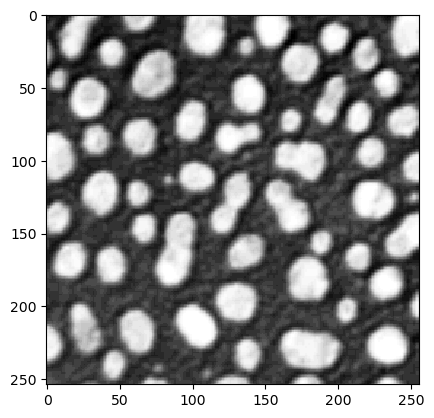

In [9]:
image = imread("https://samples.fiji.sc/blobs.png").squeeze()

cle.imshow(image)

... and for executing operations on the respective GPU.

In [10]:
image1 = cle.push(image, device=d1)
image2 = cle.push(image, device=d2)

In [11]:
blurred1 = cle.gaussian_blur(image1, sigma_x=10)
blurred2 = cle.gaussian_blur(image2, sigma_y=5)

array([[ 40.09867 ,  41.156883,  42.507847, ..., 189.27463 , 192.13885 ,
        194.54207 ],
       [ 50.640034,  51.278248,  52.21751 , ..., 202.75032 , 205.77882 ,
        208.34549 ],
       [ 56.174618,  56.587578,  57.299023, ..., 214.51335 , 217.79279 ,
        220.61708 ],
       ...,
       [ 69.12755 ,  68.62755 ,  68.08486 , ...,  63.774853,  61.41017 ,
         59.30248 ],
       [ 73.342476,  72.481384,  71.57082 , ...,  68.137054,  65.15865 ,
         62.49601 ],
       [ 82.46705 ,  81.12341 ,  79.76445 , ...,  72.538284,  69.047844,
         65.90595 ]], dtype=float32, mtype=buffer)
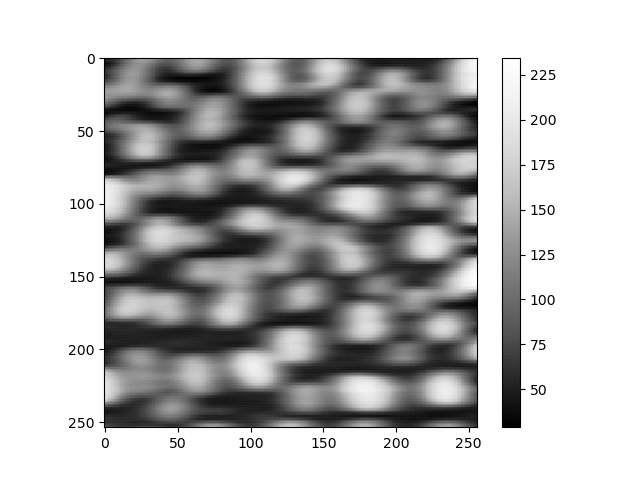
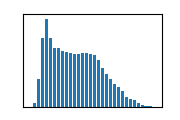

In [12]:
blurred1

array([[ 40.902157,  35.52846 ,  28.573563, ..., 225.0747  , 212.74393 ,
        212.74393 ],
       [ 40.74715 ,  36.183662,  29.756958, ..., 226.44624 , 214.88696 ,
        214.88696 ],
       [ 40.56795 ,  36.867207,  31.014425, ..., 227.67151 , 216.88551 ,
        216.88551 ],
       ...,
       [ 76.24275 ,  76.07471 ,  72.87162 , ...,  47.891773,  49.061604,
         49.061604],
       [ 79.090904,  77.96503 ,  74.195816, ...,  47.923836,  48.865387,
         48.865387],
       [ 81.93995 ,  79.81    ,  75.43991 , ...,  47.94881 ,  48.678455,
         48.678455]], dtype=float32, mtype=buffer)
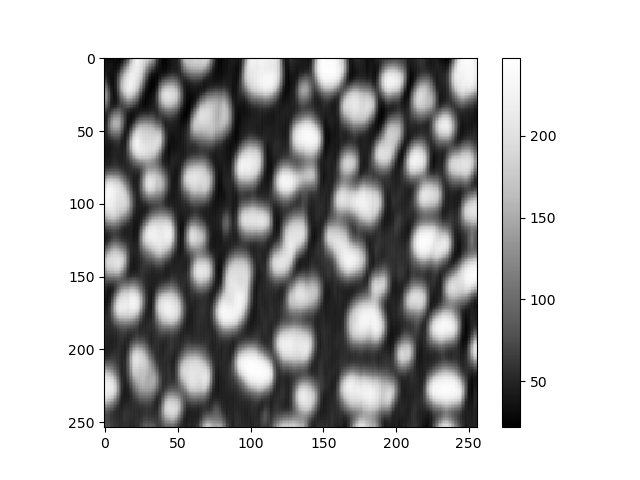
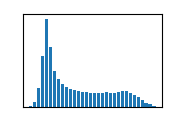

In [13]:
blurred2

Just for visualization purposes, we again print put the name of the GPU device that is used under the hood.

For demonstration purposes, we will execute a Gaussian blur with a wide radius on a large image. We will see that this operation takes some time on the individual GPUs.

In [14]:
# create a 100 MB test image
test_image = np.random.random((10, 1000, 1000)).astype(float)

# push the image to memory of both GPUs.
image1 = cle.push(test_image, device=d1)
image2 = cle.push(test_image, device=d2)

# we wait here for a second to make sure the images arrived
time.sleep(1)

In [15]:
image1.shape, image2.shape

((10, 1000, 1000), (10, 1000, 1000))

We now execute the Gaussian blur on both GPUs sequentially a couple of times and measure the time it takes.

In [16]:
for i in range(0, 5):
    print("-------------")
    start_time = time.time()
    
    # process image on first GPU
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from first GPU
    result1 = cle.pull(blurred1)
    print("Processing and pulling on", d1.name, "took", time.time() - start_time)
    
    start_time = time.time()
    # process image on second GPU
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from second GPU
    result2 = cle.pull(blurred2)
    print("Processing and pulling on", d2.name, "took", time.time() - start_time)
    
    

-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             took 0.1710817813873291
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.011061429977416992
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             took 0.1781299114227295
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.012038707733154297
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             took 0.18844914436340332
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.012167215347290039
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             took 0.19290995597839355
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.01251077651977539
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             took 0.20107603073120117
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.012193441390991211


You can clearly see that the one device is a bit slower than the other. We now repeat that experiment with a different call-order. If processing is done in parallel in the background, we will see that the processing time of each for-loop iteration is less than in the example above. 

In [17]:
for i in range(0, 5):
    print("-------------")
    start_time = time.time()
    
    # process image on both GPUs
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)

    # retrieve result from both GPUs
    result1 = cle.pull(blurred1)
    result2 = cle.pull(blurred2)
    print("Processing and pulling on", d1.name, "and", d2.name, "in parallel took", time.time() - start_time)

-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             and NVIDIA GeForce RTX 4090 in parallel took 0.17954468727111816
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             and NVIDIA GeForce RTX 4090 in parallel took 0.2030951976776123
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             and NVIDIA GeForce RTX 4090 in parallel took 0.19254183769226074
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             and NVIDIA GeForce RTX 4090 in parallel took 0.19931960105895996
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor             and NVIDIA GeForce RTX 4090 in parallel took 0.206801176071167


we can now run different kernels on different devices at the same time. 
  
Enjoy!